In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.2.1'

In [2]:
# device agnostic code 
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

**1 - Create a known Data**

In [3]:
# Create some known parameters 
weigth = 0.7
bias = 0.3 

# Create some known data 
start = 0
end = 1
step = 0.02
X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weigth * X + bias 

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

- **Split the data into train and test sets**

In [4]:
split_train = int(0.8 * len(X))
X_train,X_test,y_train,y_test = X[:split_train], X[split_train:], y[:split_train], y[split_train:]

len(X_train), len(X_test), len(y_train), len(y_test)

(40, 10, 40, 10)

- **Visualizing the Data**

In [5]:
def plot_predictions(train_data=X_train,
                    test_data=X_test,
                    train_labels=y_train,
                    test_labels=y_test,
                    predictions=None):
    
    plt.figure(figsize=(10,8))
    plt.scatter(train_data, train_labels, color='blue', label='Training Data')
    plt.scatter(test_data, test_labels, color='green', label='Testing Data')
    if predictions is not None:
        plt.scatter(test_data, predictions, color='red', label='Predictions')
    plt.legend()
    plt.show()

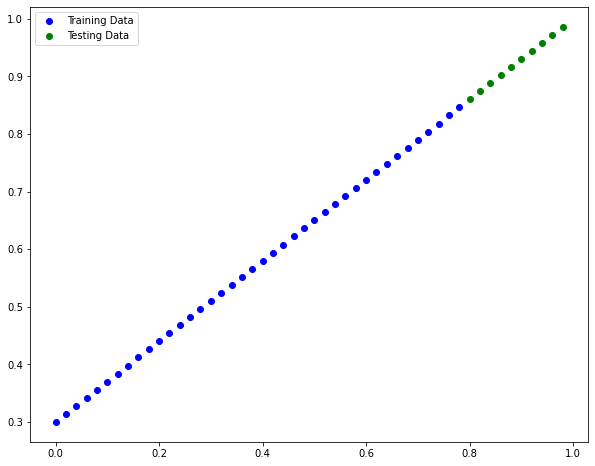

In [6]:
plot_predictions(X_train,X_test,y_train,y_test)

**2 - Build, Load or Pick a model**

In [7]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1,  # we initialize linear layer of our neural networks
                                     out_features=1)
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

In [8]:
# Instaniate and create the model 
torch.manual_seed(42)
model = LinearRegressionModel()
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

In [9]:
# Load the model to the GPU !!! 
model.to(device)
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]], device='mps:0')),
             ('linear_layer.bias', tensor([0.8300], device='mps:0'))])

- **Setting up a Loss function and Optimizer**

In [10]:
# Create a loss 
loss_fn = nn.MSELoss()

# Create an optimizer 
optimizer = torch.optim.SGD(params=model.parameters(),
                           lr=0.1)

**3 - Train the model to learn patterns**

In [11]:
torch.manual_seed(42)
epoch_count = []
train_loss_count = []
test_loss_count = []
epochs = 200

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    
    model.train()
    
    y_pred = model(X_train)
    
    loss = loss_fn(y_pred, y_train)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    model.eval()
    
    with torch.inference_mode():
        test_pred = model(X_test)
        
        test_loss = loss_fn(test_pred, y_test)
        
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        train_loss_count.append(loss.cpu().detach().numpy())
        test_loss_count.append(test_loss.cpu().detach().numpy())
        print(f"Epochs:{epoch} | Train Loss:{loss} | Test Loss:{test_loss}")

Epochs:0 | Train Loss:0.3084445595741272 | Test Loss:0.19119670987129211
Epochs:10 | Train Loss:0.0023296137806028128 | Test Loss:0.0004770881205331534
Epochs:20 | Train Loss:0.0006379926926456392 | Test Loss:0.0024493359960615635
Epochs:30 | Train Loss:0.0005237426958046854 | Test Loss:0.0022332894150167704
Epochs:40 | Train Loss:0.00043536644079722464 | Test Loss:0.0018697625491768122
Epochs:50 | Train Loss:0.00036193159758113325 | Test Loss:0.0015552403638139367
Epochs:60 | Train Loss:0.0003008826752193272 | Test Loss:0.0012929689837619662
Epochs:70 | Train Loss:0.00025013103731907904 | Test Loss:0.0010748807108029723
Epochs:80 | Train Loss:0.000207940858672373 | Test Loss:0.0008935779333114624
Epochs:90 | Train Loss:0.00017286599904764444 | Test Loss:0.0007428491371683776
Epochs:100 | Train Loss:0.00014370799181051552 | Test Loss:0.0006175530725158751
Epochs:110 | Train Loss:0.00011946809536311775 | Test Loss:0.0005133839440532029
Epochs:120 | Train Loss:9.931693057296798e-05 | Tes

**4 - Make some inferences and predictions**

In [12]:
model.eval()
with torch.inference_mode():
    y_preds = model(X_test)
y_preds = y_preds.cpu()
y_preds

tensor([[0.8520],
        [0.8655],
        [0.8791],
        [0.8927],
        [0.9063],
        [0.9199],
        [0.9335],
        [0.9471],
        [0.9607],
        [0.9743]])

- **Plot Predictions**

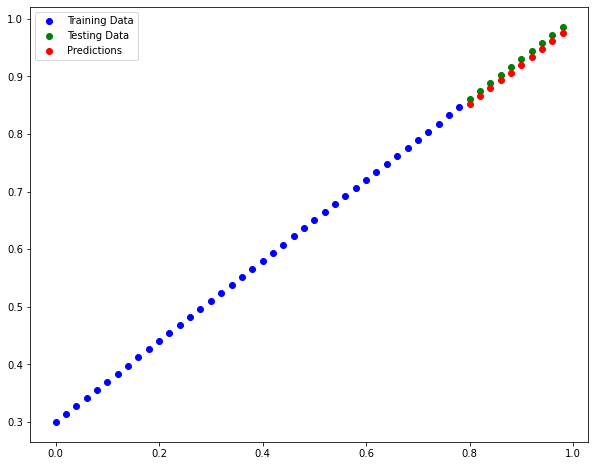

In [13]:
plot_predictions(predictions=y_preds)

- **Plot the train and loss curve**

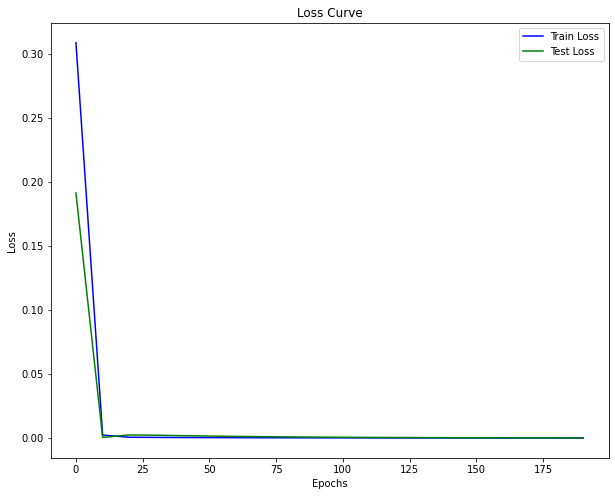

In [14]:
plt.figure(figsize=(10,8))
plt.plot(epoch_count, train_loss_count, color='blue', label='Train Loss')
plt.plot(epoch_count, test_loss_count, color='green', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

**5 - Save and Load our model**

- **Save**

In [15]:
from pathlib import Path

MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = '01_pytorch_workflow_model.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

PosixPath('models/01_pytorch_workflow_model.pth')

In [16]:
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

- **Load**

In [17]:
loaded_model = LinearRegressionModel()
torch.manual_seed(42)
loaded_model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

In [18]:
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [19]:
loaded_model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6795]])),
             ('linear_layer.bias', tensor([0.3084]))])

In [21]:
loaded_model.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model(X_test.cpu())
loaded_model_preds

tensor([[0.8520],
        [0.8655],
        [0.8791],
        [0.8927],
        [0.9063],
        [0.9199],
        [0.9335],
        [0.9471],
        [0.9607],
        [0.9743]])

In [22]:
loaded_model_preds == y_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])